# Manifold Learning

PCA can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points. While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are *nonlinear* relationships within the data. To address this, we can turn to a class of methods known as *manifold learning* —a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces. Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learning

To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.

In [2]:
def my_name(N=1000, rseed=10):
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'FAZIL', va='center', ha='center', weight='bold', size=85)
    fig.savefig('fazil.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    data = imread('fazil.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Let's call the function and visualize the resulting data:

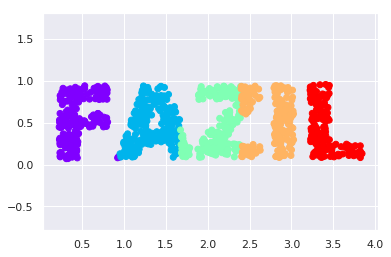

In [5]:
X = my_name(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

This data form will help us to see visually what these algorithms are doing.

## Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "FAZIL" will still be apparent.
For example, if we use a rotation matrix to rotate the data, the *x* and *y* values change, but the data is still fundamentally the same:

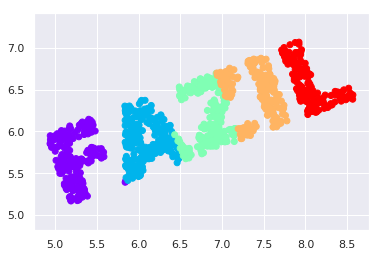

In [6]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

This tells us that the *x* and *y* values are not necessarily fundamental to the relationships in the data.
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.

In [7]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

As promised, for our *N*=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here:

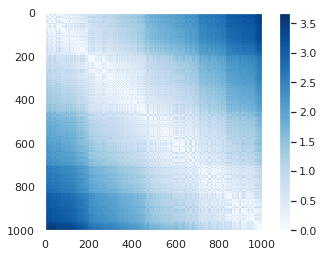

In [8]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

In [9]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive. In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data.

Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into *x* and *y* coordinates is rather difficult. This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data

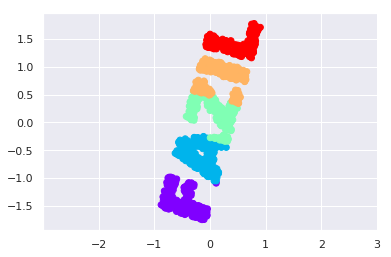

In [10]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')
plt.show()

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

## MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [11]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

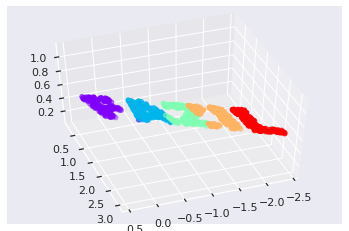

In [12]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.
The result recovers a representation of the original data:

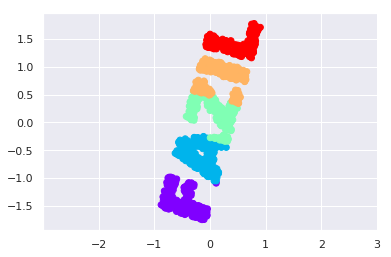

In [13]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')
plt.show()

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.

## Nonlinear Embeddings: Where MDS Fails

We considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces. Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.

In [14]:
def make_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

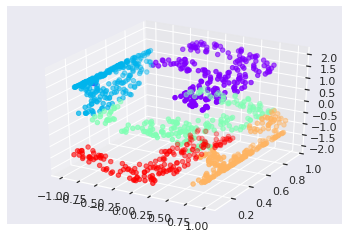

In [15]:
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize)
plt.show()

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

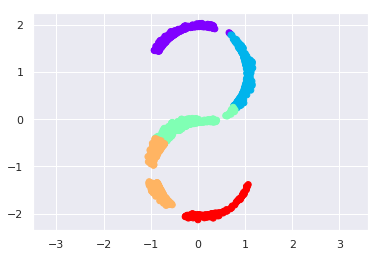

In [16]:
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')
plt.show()

The best two-dimensional *linear* embeding does not unwrap the S-curve, but instead throws out the original y-axis.

## Nonlinear Manifolds: Locally Linear Embedding

We can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding. But what if we instead modified the algorithm such that it only preserves distances between nearby points? The resulting embedding would be closer to what we want.

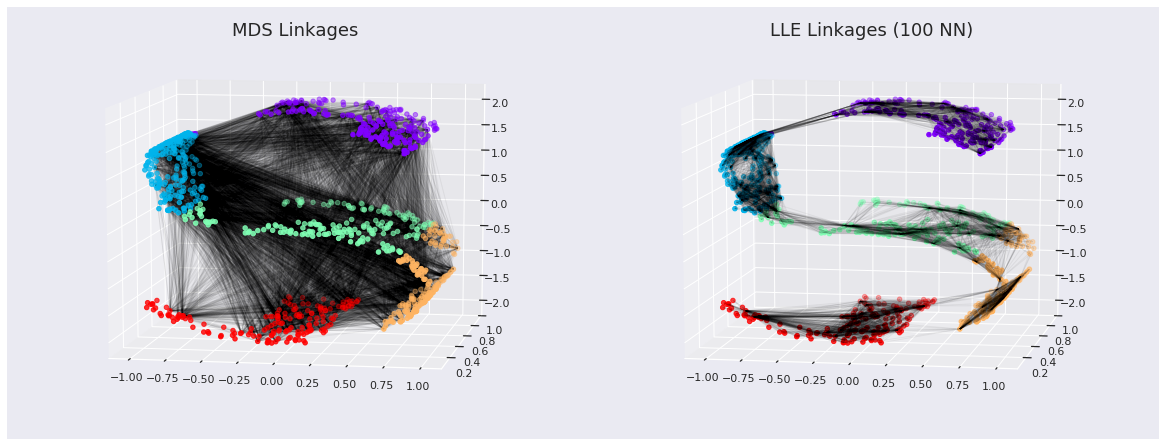

In [18]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors

# construct lines for MDS
rng = np.random.RandomState(10)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)


Here each faint line represents a distance that should be preserved in the embedding.
On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset.
On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving *all* distances, it instead tries to preserve only the distances between *neighboring points*: in this case, the nearest 100 neighbors of each point.

We can see why MDS fails: there is no way to flatten this data while preserving the length of every line drawn between the two points. For the right panel, on the other hand, things look a bit more optimistic. what LLE does is unrolling the data in a way that keeps the lengths of the lines approximately the same through a global optimization of a cost function reflecting this logic.

In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion

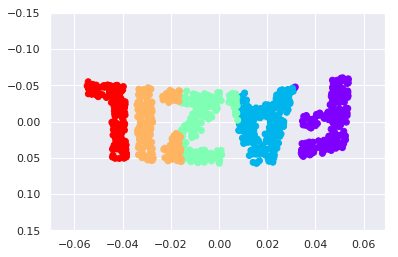

In [19]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15)
plt.show()

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

## Manifold Methods vs PCA

Manifold learning techniques are rarely used for anything more than simple qualitative visualization of high-dimensional data.

- In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.
- In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
- The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
- In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets us find the output dimension based on the explained variance.
- In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
- In manifold learning the computational expense of manifold methods scales as O(N^2) or O(N^3). For PCA, there exist randomized approaches that are generally much faster.

The only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason it is better to explore data with manifold methods only after first exploring them with PCA.

## Isomap on Faces

A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels. In other words, the images can be thought of as data points in a 2,914-dimensional space.

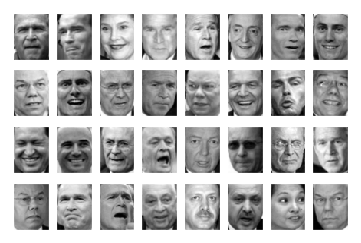

In [21]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images.
One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

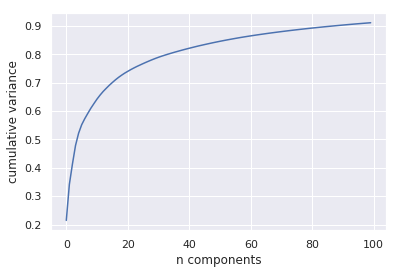

In [22]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful.
We can compute an Isomap embedding on these faces using the same pattern shown before:

In [23]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

The output is a two-dimensional projection of all the input images.
To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

In [24]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Calling this function now, we see the result:

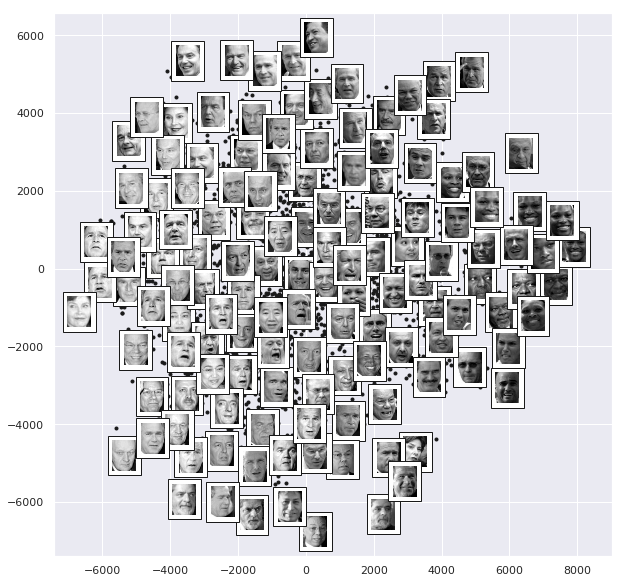

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top.
This gives us a nice visual indication of some of the fundamental features in our data.

We could then go on to classify this data (perhaps using manifold features as inputs to the classification algorithm) using SVM.

## Visualizing Structure in Digits

In [26]:
from sklearn.manifold import * 
from sklearn.datasets import load_digits 
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import SparseRandomProjection

digits = load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

In [38]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(11, 8))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Text(0.5, 1.0, 'A selection from the 64-dimensional digits dataset')

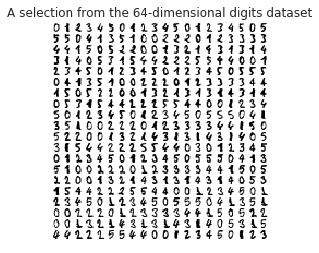

In [35]:
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

Computing random projection


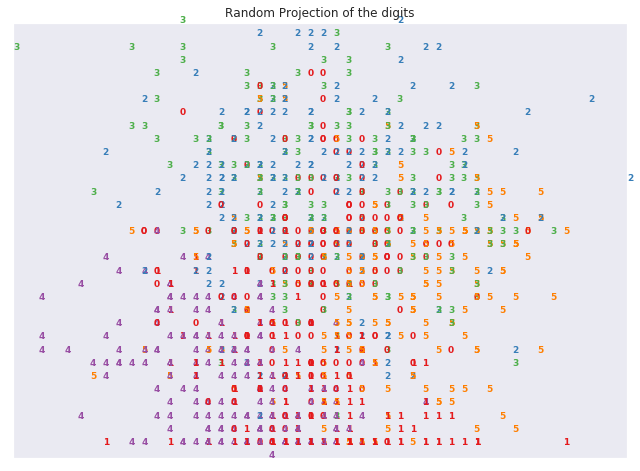

In [39]:
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

Computing PCA projection


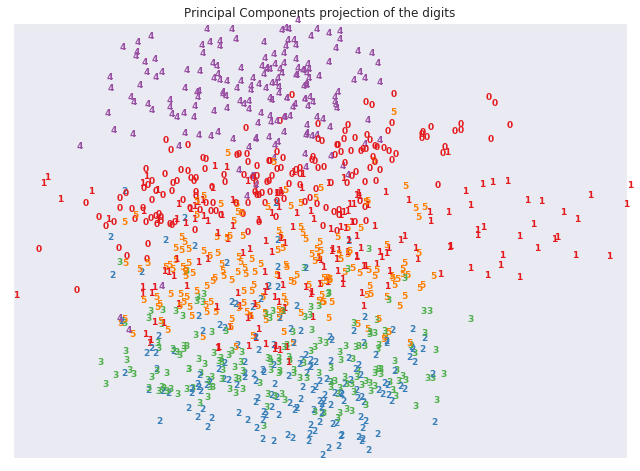

In [40]:
# Projection on to the first 2 principal components
print("Computing PCA projection")
X_pca = TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, "Principal Components projection of the digits")

Computing Linear Discriminant Analysis projection


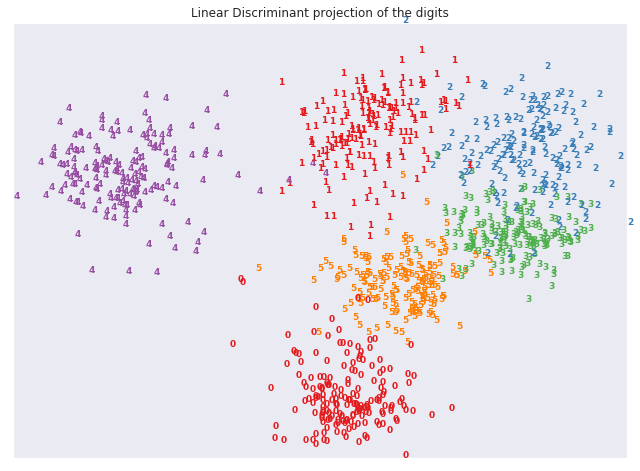

In [41]:
# Projection on to the first 2 linear discriminant components
print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
X_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda, "Linear Discriminant projection of the digits")

Computing Isomap embedding


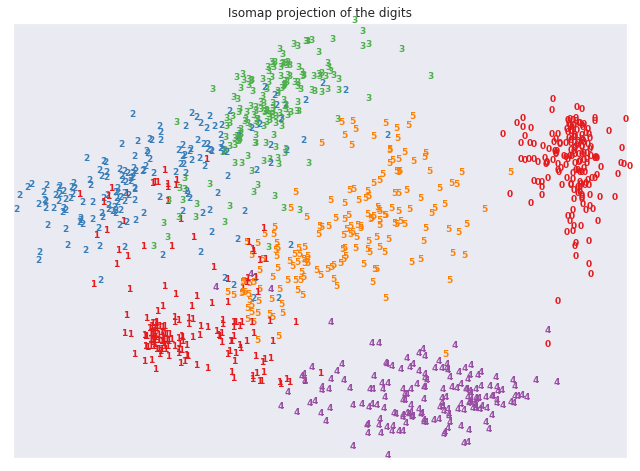

In [42]:
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
X_iso = Isomap(n_neighbors, n_components=2).fit_transform(X)
plot_embedding(X_iso, "Isomap projection of the digits")

Computing LLE embedding
Done. Reconstruction error: 1.63544e-06


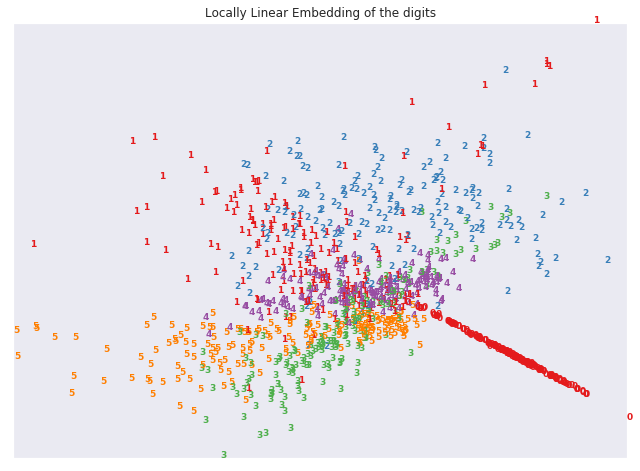

In [43]:
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='standard')
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle, "Locally Linear Embedding of the digits")

Computing modified LLE embedding
Done. Reconstruction error: 0.360446


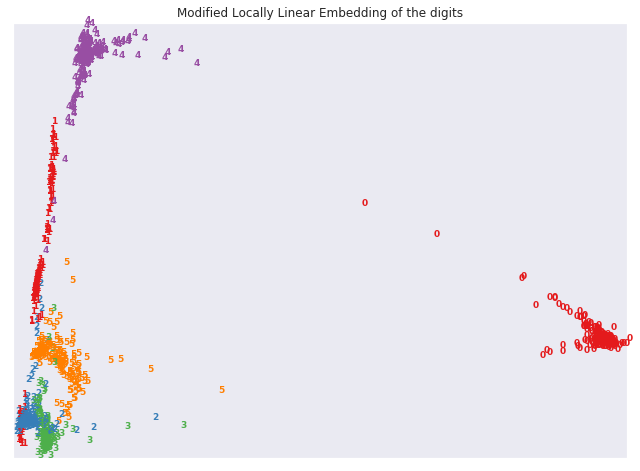

In [44]:
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='modified')
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle, "Modified Locally Linear Embedding of the digits")

Computing Hessian LLE embedding
Done. Reconstruction error: 0.212808


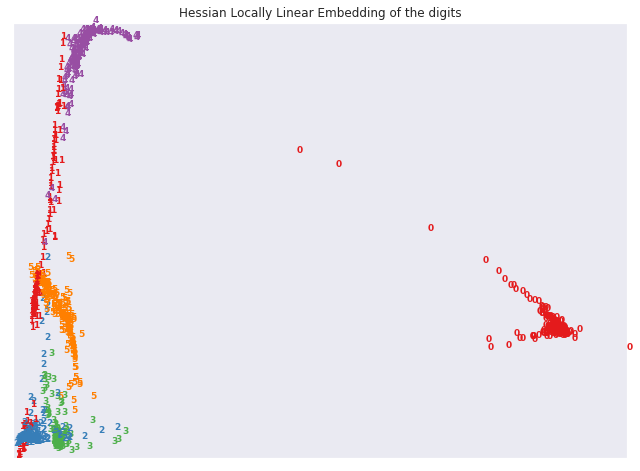

In [45]:
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='hessian')
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle, "Hessian Locally Linear Embedding of the digits")

Computing LTSA embedding
Done. Reconstruction error: 0.212804


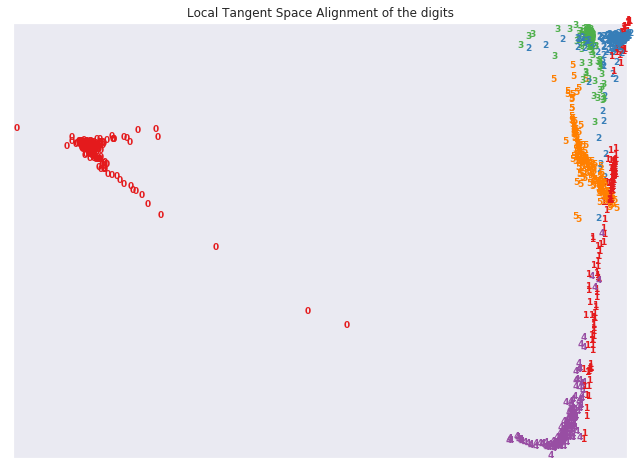

In [46]:
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='ltsa')
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa, "Local Tangent Space Alignment of the digits")

Computing MDS embedding
Done. Stress: 162945225.042870


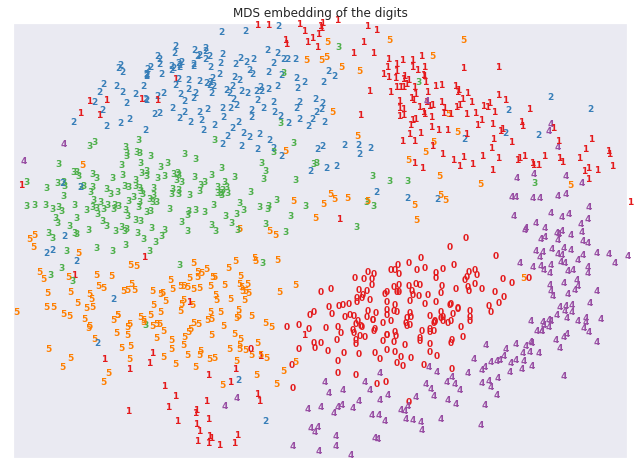

In [47]:
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = MDS(n_components=2, n_init=1, max_iter=100)
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds, "MDS embedding of the digits")

The RandomTreesEmbedding is not technically a manifold embedding method, as it learn a high-dimensional representation on which we apply a dimensionality reduction method. However, it is often useful to cast a dataset into a representation in which the classes are linearly-separable.

Computing Totally Random Trees embedding


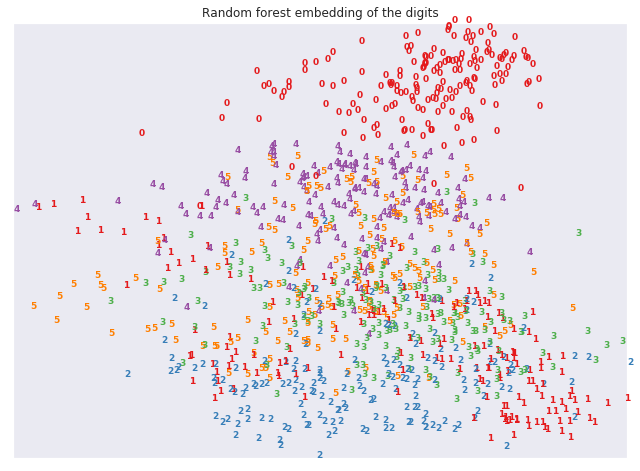

In [48]:
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = RandomTreesEmbedding(n_estimators=200, random_state=0, max_depth=5)
X_transformed = hasher.fit_transform(X)
pca = TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)
plot_embedding(X_reduced, "Random forest embedding of the digits")

Computing Spectral embedding


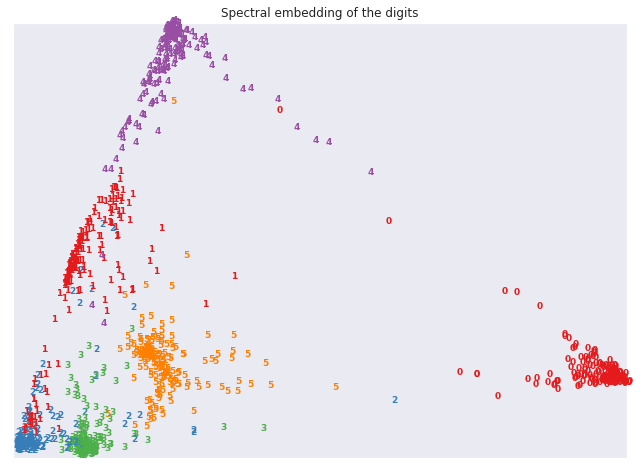

In [49]:
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
X_se = embedder.fit_transform(X)
plot_embedding(X_se, "Spectral embedding of the digits")

t-SNE will be initialized with the embedding that is generated by PCA, which is not the default setting. It ensures global stability of the embedding, i.e., the embedding does not depend on random initialization.

Computing t-SNE embedding


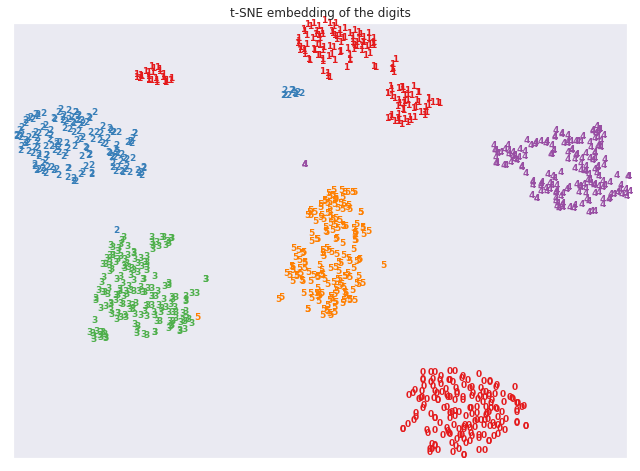

In [50]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,  "t-SNE embedding of the digits")


- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings.
- For data that is highly clustered, *t-distributed stochastic neighbor embedding* (t-SNE) seems to work very well, though can be very slow compared to other methods.